**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

C:\Users\venka\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
## train dataset 
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
##  validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List of all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

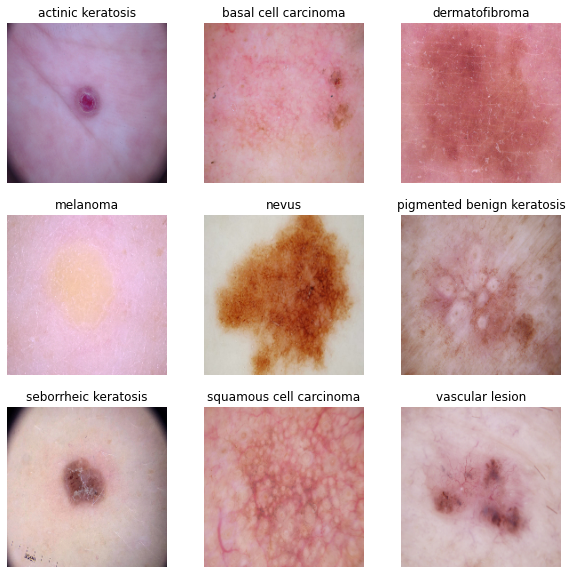

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### CNN Model

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Using Adam optimiser and categorical_crossentropy loss function
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 503ms/step - loss: 2.0399 - accuracy: 0.2299 - val_loss: 2.3300 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 29s 510ms/step - loss: 1.7346 - accuracy: 0.3728 - val_loss: 2.7625 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 29s 523ms/step - loss: 1.4993 - accuracy: 0.4794 - val_loss: 2.3258 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 29s 513ms/step - loss: 1.3797 - accuracy: 0.5128 - val_loss: 2.6847 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 28s 506ms/step - loss: 1.3395 - accuracy: 0.5391 - val_loss: 2.2957 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 29s 512ms/step - loss: 1.2362 - accuracy: 0.5692 - val_loss: 3.2870 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 29s 522ms/step - loss: 1.2113 - accuracy: 0.5603 - val_loss: 2.7672 - val_accuracy: 0.1739

### Visualizing training results

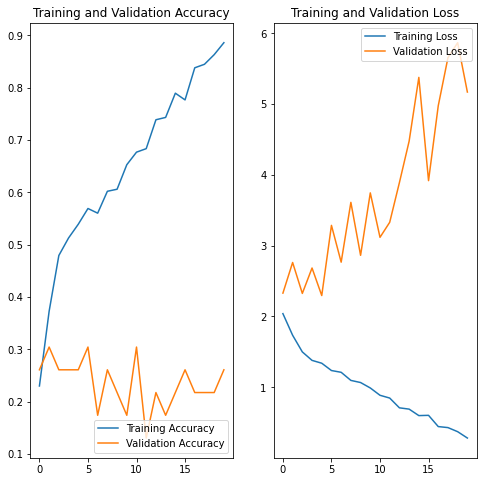

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation

#### The Model is Overfit as the Training accuracy is 88.6% and Validation accuracy is 26%. As there is so much gap between these accuracies the model is overfit to training data
***

### Data Augmentation strategy

In [17]:
# Augmentation using Image data generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


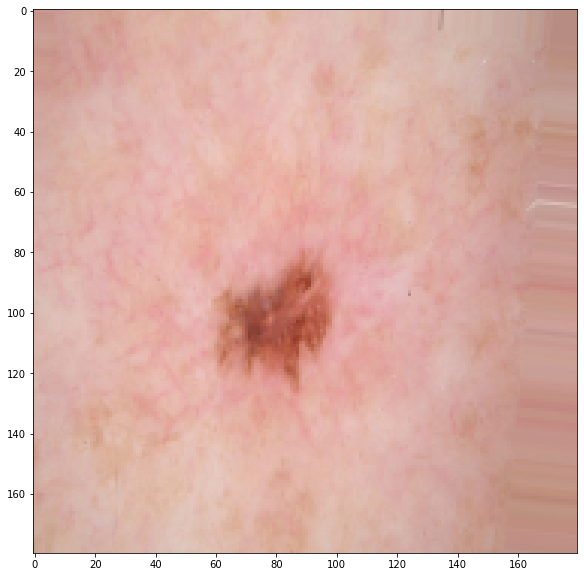

In [60]:
#Preview of one img instance created using augmentor
plt.figure(figsize=(10, 10))
image = train_batches.next()[0][1].astype('uint8')
plt.imshow(image)
plt.show()

### Create the model, compile and train the model


In [19]:
## We will use Dropout layer as the model is overfitting in our previous observation

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))




### Compiling the model

In [22]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [24]:
## train model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 32s 2s/step - loss: 1.2775 - accuracy: 0.4551 - val_loss: 1.5363 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 28s 2s/step - loss: 0.9910 - accuracy: 0.4978 - val_loss: 1.2529 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 28s 2s/step - loss: 0.9245 - accuracy: 0.5438 - val_loss: 1.4375 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - 28s 2s/step - loss: 0.7469 - accuracy: 0.6539 - val_loss: 1.8771 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 28s 2s/step - loss: 0.7426 - accuracy: 0.6449 - val_loss: 1.4926 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - 28s 2s/step - loss: 0.7658 - accuracy: 0.6404 - val_loss: 1.3329 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 7/20
14/14 [==============================] - 28s 2s/step - loss: 0.6870 - a

### Visualizing the results

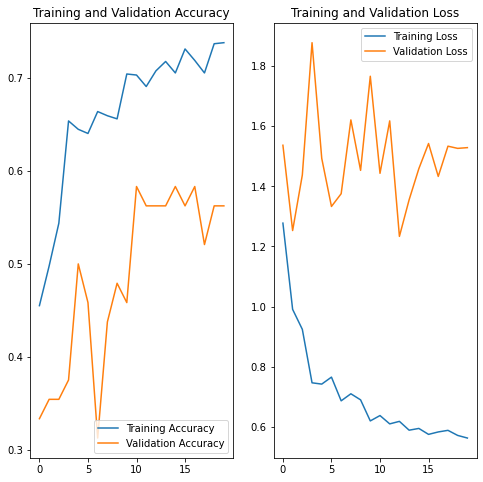

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation

#### The model has shown sign of reduction in overfit as the gap between Training accuracy and Validation accuracy has reduced. Now the model is more better after data augmentation with validation accuracy at 56%.
***

#### Let us find the distribution of classes in the training dataset.

<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

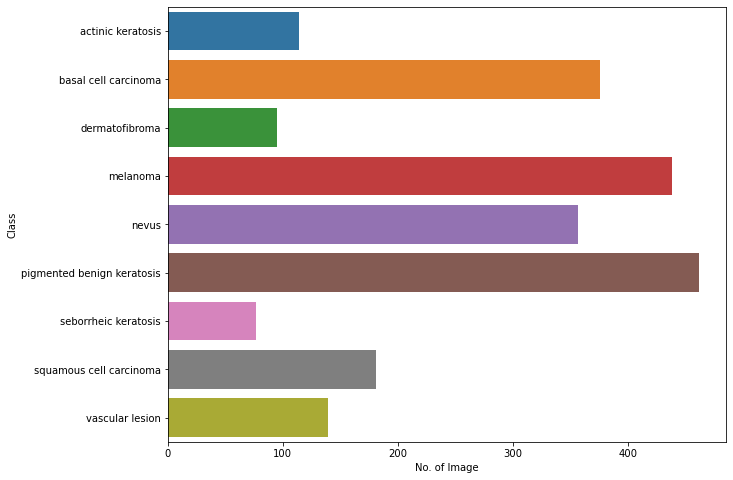

In [59]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Observation
#### Class "seborrheic keratosis" has the least number of image samples. "Pigmented benign keratosis" dominates the data in the number of samples. There is lot of class imbalance and this needs to rectified to reduce the bias.
***


#### We will use `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset= "D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F065A9AC0>: 100%|██████████| 500/500 [00:01<00:00, 346.90 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F01C0DC10>: 100%|██████████| 500/500 [00:01<00:00, 484.39 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F039DDC40>: 100%|██████████| 500/500 [00:01<00:00, 489.13 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x19F03A048B0>: 100%|██████████| 500/500 [00:05<00:00, 86.89 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x19F03873430>: 100%|██████████| 500/500 [00:04<00:00, 109.55 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F01FE7550>: 100%|██████████| 500/500 [00:01<00:00, 418.67 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x19F03897670>: 100%|██████████| 500/500 [00:02<00:00, 213.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F01C33130>: 100%|██████████| 500/500 [00:01<00:00, 330.47 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to D:\ML&AI\CNN\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19F50A0AA00>: 100%|██████████| 500/500 [00:01<00:00, 492.50 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2ede36dd-8747-4658-a2c7-766c49af7a6b.jpg',
 'D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7f4bbb15-2629-486e-ac99-a2ef8bbf9c15.jpg',
 'D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_30bbbb76-aa7e-43d6-a746-1fb671b43d3a.jpg',
 'D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_37256254-7ba5-4600-9d1d-65454b9f73d9.jpg',
 'D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\outpu

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2 

In [43]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### Training dataset with augmented data

In [44]:
data_dir_train= "D:\\ML&AI\\CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model creation with normalization

In [47]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))
model.add(BatchNormalization())
#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 89, 89, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0

#### Compile the model 

In [55]:
#Compile the Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### Train the model

In [56]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.6003 - accuracy: 0.4560
Epoch 1: val_accuracy improved from -inf to 0.11507, saving model to model.h5
169/169 [==============================] - 106s 599ms/step - loss: 1.6003 - accuracy: 0.4560 - val_loss: 3.0598 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.6244
Epoch 2: val_accuracy improved from 0.11507 to 0.23460, saving model to model.h5
169/169 [==============================] - 101s 599ms/step - loss: 1.0689 - accuracy: 0.6244 - val_loss: 2.4431 - val_accuracy: 0.2346
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.7268
Epoch 3: val_accuracy improved from 0.23460 to 0.38604, saving model to model.h5
169/169 [==============================] - 100s 589ms/step - loss: 0.7924 - accuracy: 0.7268 - val_loss: 1.7235 - val_accuracy: 0.3860
Epoch 4/30
169/169 [==============================] - ETA: 0s - los

#### Visualize the model results

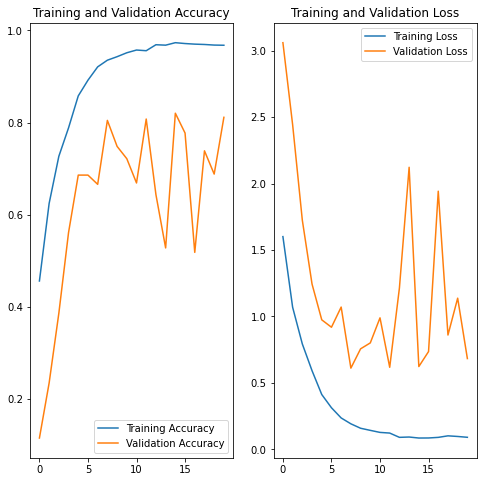

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# due to early stopping at 20 epochs
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Prediction

1/1 [==============================] - 0s 26ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


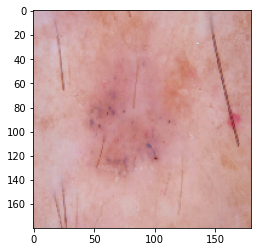

In [63]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[0],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

### Final Conclusion: 
* Final Model has Training accuracy of 96.7% and validation accuracy of 81%. 
* The Model is able to predict images correctly for 81% of unseen data is very good characteristic of the model where it is neither overfit nor underfit.
* The Augmentor to balance the classes did help to improve the validation accuracy to 81% from 56%
